In [ ]:
"""
André Lucas, Enzo D'innocenzo, Anne Opschoor and Victor van der Wel
"""
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy.optimize import minimize,Bounds, LinearConstraint
from scipy.stats import multivariate_t
from numba import jit
from numba import njit, prange
import math
import multiprocessing
from multiprocessing import Pool

In [ ]:
#data =open('all crsp monthly ret prc exchcd shrout sic 1926-2016.txt','r')    #Herskovic et al. Data  (Crazy long data set lol)

In [ ]:
#print(data.read())

#### generate data

In [ ]:
NUMBA_CAPTURED_ERRORS='new_style'

Generate data by simulating

\begin{align}
\mathbf{y}_t = (\mathbb{I}_N-\mathbf{R}_t\mathbf{W}_t)^{-1}\mathbf{X}_t\mathbf{\beta} + (\mathbb{I}_N-\mathbf{R}_t\mathbf{W}_t)^{-1}\mathbf{ɛ}_t,
\end{align}

In [ ]:
@jit(nopython=True)
def generate_W_matrix(iN):
    # Generate a random matrix that contains the spatial weights

    #np.random.seed(10)
    iW =np.random.rand(iN, iN)
    iW /= iW.sum(axis=1)[:, np.newaxis] # the rows sum to 1

    return iW

@jit(nopython=True)
def generatate_R_values(iT):
    #generate time-varying spatial spillovers

    R1 = 0.3+0.4*np.cos(2*np.pi*np.linspace(0,iT, num=iT)/iT)
    R2 = 0.3+0.4*np.sin(2*np.pi*np.linspace(0,iT, num=iT)/iT)
    R3 = 0.3+0.4*np.cos(4*np.pi*np.linspace(0,iT, num=iT)/iT)

    return R1,R2#,R3

In [ ]:
def fGenerateSAR(iT,iN,iK,iNu,iBeta,iStDev):
    g=2
    #np.random.seed(10)
    X = np.random.randn(iT*iN, iK)

    Y = np.zeros((iT, iN))
    iW =generate_W_matrix(iN)
    R = generatate_R_values(iT)
    Rmat = np.vstack([[R[j] for i in range(int(iN/g))] for j in range(g)])
    Cm = np.repeat(np.array([i for i in range(g)]),int(iN/g))
    for t in range(iT):
      iR = np.diagflat(Rmat[:,t])

      #np.random.seed(t) # make sure to have the same random values

      value = np.linalg.inv(np.eye(iN)-np.dot(iR,iW)) @(X[t*iN:(t+1)*iN] *iBeta) + np.linalg.inv(np.eye(iN)-np.dot(iR,iW)) @((multivariate_t.rvs(np.zeros(iN), np.eye(iN) * iStDev, df=iNu, size=1).reshape(-1,1)))

      Y[t] = value.T[0]

    return (Y,iW,X,Cm,Rmat.T)


\begin{align}
&\mathbf{y}_t = \mathbf{R}_t\mathbf{W}_t\mathbf{y}_t + \mathbf{ɛ}_t, \quad\quad \mathbf{ɛ}_t\overset{i.i.d.}{\sim} p_{\epsilon}(\mathbf{ɛ}_t;\Sigma,v)\\
&\mathbf{f}_t = \text{diag}(\mathbf{R}_t) = (\mathbf{R}_{1,1,t},\dots, \mathbf{R}_{N,N,t})^T\\
&\mathbf{f}_{t+1} = \mathbf{\omega} + \mathbf{B}_t\mathbf{f}_t + \mathbf{A}_t\mathbf{s}_t\\
\\&\text{where}\\
\\
&\mathbf{s}_t = |\mathbf{Z}_t| \cdot w_t \cdot \text{diag}(\mathbf{\Sigma}^{-1}\mathbf{e}_ty_t^{*T}) - \text{diag}(\mathbf{W}_t\mathbf{Z}_t^{*}),\\[1em]
&y_t^{*} = \mathbf{W}_t\mathbf{y}_t\\[1em]
&\mathbf{e}_t = \mathbf{y}_t-\mathbf{R}_t\mathbf{W}_t\mathbf{y}_t,\\[1em]
&\mathbf{Z}_t = \mathbf{I}_N-\mathbf{R}_t\mathbf{W}_t,\\[1em]
& \mathbf{Z}_t^{*}=|\mathbf{Z}_t|\mathbf{Z}_t^{-1}
\end{align}



#### Filter

In [ ]:
def fFilterSAR(Y,MinlenCluster,params):
    """
    Input: Y,params
    Y contains:           (observables)
    - vData: (float)    a TxN matrix with observations
    - iW:    (float)    a NxN matrix with spatial weights
    - X:     (float)    a matrix of regressors
    - Cm:    (int)      a N vector of cluster memberships
    - R:     (float)    a Txk matrix of spatial spillovers

    params contains:      (optimised by maximum likelihood estimation)
    - iB     (float)    a scalar variable
    - iVt_int(float)    a scalar variable
    - omega1,2,3 (float)a scalar variable for the updating equation

    returns
    the filtered spatial spillovers (Txg matrix) and the log-likelihood contributions (Tx1 vector)
    """
    vData, iW, X,Cm, R = Y
    g=2
    iB=params[0]
    iVt_int = params[1]
    iFt= np.array([params[2:]])
    dOmega= np.array([params[2:]]).reshape(-1,1)

    iT,iN= vData.shape

    def LOCAL_MakeHtmat(Cm,iN,g):
      matrix = np.zeros((iN, g),dtype=np.float64)

      for i in range(iN):

        matrix[i,Cm[i]]=1

      return matrix

    Ht=LOCAL_MakeHtmat(Cm,iN,g)

    def validate_cluster_membership(Cm,Ht,g):
      if MinlenCluster==0:
         return True

      elif min(np.sum(Ht,axis=0)) <MinlenCluster:
          print(np.sum(Ht,axis=0))
          print("*** 1!!an invalid clustermembership value was encountered!! ***")

          return False

      elif len(np.unique(Cm))!=g:
          print("***2 !!an invalid clustermembership value was encountered!! ***")

          return False

      else:

        for value in Cm:

          if value != np.int64(value):
            print("***3 !!a non-integer clustermembership value was encountered!! ***")

            return False

          elif value < 0 or value >= g:

            print("*** 4!!an invalid clustermembership value was encountered!! ***")

            return False

      return True       #iedere unieke waarde van Cm controleren

    if not validate_cluster_membership(Cm,Ht,g):

      pass
    else:
      return fRunLoop(iB,iVt_int,iFt[0],dOmega,iT,iN,g,Ht,vData,iW)


#@njit(parallel=True)
@jit(nopython=True)
def fRunLoop(iB,iVt_int,iFt,dOmega,iT,iN,g,Ht,vData,iW):
    iNu = 5
    vFt = np.zeros((iT,g))
    vLikelihoodValues = np.zeros(iT)
    CovMatrix = np.diagflat(np.array([np.var(vData.T[i]) for i in range(iN)]))

    iBeta = np.zeros(g)                             #for now we only use beta=0
    B = np.eye(g) * iB
    A = np.eye(g) * iVt_int
    invCov= 1/ np.diag(CovMatrix)
    wtop = (1+ (iN+2) / (iNu-2))
    for i1 in range(iT):   #omschrijven naar loop over de columns g ipv over de rijen
      vFt[i1] = iFt
      iR = np.diagflat(Ht@vFt[i1].reshape(-1,1))     #vanwege numba kunnen we niet iFt.T gebruiken maar alleen vFt[i].T

      yt=vData[i1].reshape(-1,1)
      Ystar = np.dot(iW,yt).reshape(-1,1)

      #scaling paramter that controls spatial stability
      Zt = np.eye(iN)-np.dot(iR,iW)
      logdetZt = np.linalg.slogdet(Zt)[1]
      Zt_star = np.exp(logdetZt)*np.linalg.inv(Zt)

      e_t= yt-np.dot(iR,iW)@yt #-np.dot(X[i1*iN:(i1+1)*iN],iBeta).reshape(-1,1) #calculate residuals
      et_cov= (invCov@e_t**2)[0]

      autoCov = (1+ et_cov/(iNu-2))
      vLikelihoodValues[i1] =  logdetZt- 0.5 * (iNu + iN) * np.log(autoCov)  #stack likelihood contributions

      # if the eigenvalue of R_tW_t >1 in absolute value then adjust the stepsize to zero
      bin = 0 if max(np.abs(np.linalg.eigh(np.dot(iR,iW))[0]))>=1 else 1

      #calculate updating step
      w_t = wtop/ autoCov
      s_t = np.exp(logdetZt) * Ht.T@ (w_t * invCov * np.dot(e_t, Ystar.T) - np.sum(iW * Zt_star.T, axis=1).reshape(-1, 1))

      value = (np.eye(g)-B) @ dOmega + B @ vFt[i1].reshape(-1,1)+ A @ s_t *bin
      iFt = value.T[0]                    #omdat numba niet goed werkt transpose

    vLikelihoodValues += math.lgamma((iNu + iN) / 2) - math.lgamma(iNu / 2)- 0.5*iN*np.log(iNu-2) - 0.5 *iN* np.log(np.pi)-0.5*np.linalg.slogdet(CovMatrix)[1]
    return (vFt,vLikelihoodValues)

In [ ]:
x1= fGenerateSAR(1000,2,1,5,np.zeros(1),0.01)

In [ ]:
k=fFilterSAR(x1,1,([0.98405718, 0.02567924 ,0.32042452 ,-0.13116496]))

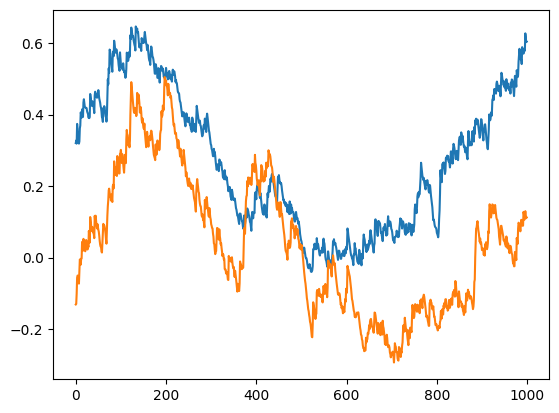

In [ ]:
plt.plot(k[0])

#### Support functions

In [ ]:
###########################################################
### vh= _gh_stepsize(vP)
@jit(nopython=True)
def _gh_stepsize(vP):
    """
    Purpose:
        Calculate stepsize close (but not too close) to machine precision

    Inputs:
        vP      1D array of parameters

    Return value:
        vh      1D array of step sizes
    """

    vh = 1e-8*(np.fabs(vP)+1e-8)   # Find stepsize
    vh = np.maximum(vh, 5e-6)      # Don't go too small

    return vh

In [ ]:
###########################################################
### vG= gradient_2sided(fun, vP, *args)
@jit(nopython=True)
def gradient_2sided(fun, vP, *args):
    """
    Purpose:
        Compute numerical gradient, using a 2-sided numerical difference
        Author:Charles Bos, following Kevin Sheppard's hessian_2sided, with
        ideas/constants from Jurgen Doornik's Num1Derivative

    Inputs:
        fun     function, as used for minimize()
        vP      1D array of size iP of optimal parameters
        args    (optional) extra arguments

    Return value:
        vG      iP vector with gradient

    See also:
        scipy.optimize.approx_fprime, for forward difference
    """

    iP   =  np.size(vP)
    vP   =  vP.reshape(iP)      # Ensure vP is 1D-array

    #  f  = fun(vP, *args)      # central function value is not needed
    vh= _gh_stepsize(vP)
    mh   =  np.diag(vh)         # Build a  diagonal matrix out of h

    fp = np.zeros(iP)
    fm = np.zeros(iP)
    for i in range(iP):         # Find f(x+h), f(x-h)
        fp[i] =  fun(vP+mh[i], *args)
        fm[i] =  fun(vP-mh[i], *args)

    vhr = (vP +  vh) - vP       # Check for effective stepsize right
    vhl = vP - (vP - vh)        # Check for effective stepsize left
    vG= (fp -  fm) /  (vhr +  vhl)  # Get central gradient

    return vG

In [ ]:
###########################################################
### mG= jacobian_2sided(fun, vP, *args)

def jacobian_2sided(fun, vP, *args):
    """
    Purpose:
        Compute numerical jacobian, using a 2-sided numerical difference

    Author:
        Charles Bos, following Kevin Sheppard's hessian_2sided, with
        ideas/constants from Jurgen Doornik's Num1Derivative

    Inputs:
        fun     function, return 1D array of size iN
        vP      1D array of size iP of optimal parameters
        args    (optional) extra arguments

    Return value:
        mG      iN x  iP   matrix with jacobian

    See also:numdifftools.Jacobian(), for similar output
    """
    iP = np.size(vP)
    vP = vP.reshape(iP)        # Ensure vP is 1D-array
    vF = fun(vP, *args)        # evaluate function, only to get size
    iN = vF.size
    vh= _gh_stepsize(vP)
    mh   =  np.diagflat(vh)        # Build a  diagonal matrix out of h
    mGp = np.zeros((iN, iP))
    mGm = np.zeros((iN, iP))
    for i in   range(iP):     # Find f(x+h), f(x-h)
        mGp[:,i] =  fun(vP+mh[i], *args)
        mGm[:,i] =  fun(vP-mh[i], *args)
    vhr = (vP +  vh) - vP    # Check for effective stepsize right
    vhl = vP   -  (vP -  vh)    # Check for effective stepsize left
    mG= (mGp -  mGm) / (vhr +  vhl)  # Get central jacobian
    return mG

In [ ]:
###########################################################
### mH= hessian_2sided(fun, vP, *args)

def hessian_2sided(fun, vP, *args):
    """
    Purpose:
        Compute numerical hessian, using a  2-sided numerical difference

    Author:Kevin Sheppard, adapted by Charles Bos

    Source:https://www.kevinsheppard.com/Python_for_Econometrics

    Inputs:
        fun     function, as used for minimize()
        vP      1D array of size iP of optimal parameters
        args    (optional) extra arguments

    Return value:
        mH      iP x  iP matrix with symmetric hessian
    """
    iP = np.size(vP,0)
    vP= vP.reshape(iP)    # Ensure vP is 1D-array
    f = fun(vP, *args)
    vh= _gh_stepsize(vP)
    vPh = vP + vh
    vh = vPh - vP

    mh = np.diag(vh)      # Build a  diagonal matrix out of vh

    fp   =  np.zeros(iP)
    fm   =  np.zeros(iP)
    for i in range(iP):
        fp[i] =  fun(vP+mh[i], *args)
        fm[i] =  fun(vP-mh[i], *args)

    fpp = np.zeros((iP,iP))
    fmm = np.zeros((iP,iP))
    for i in   range(iP):
        for j in   range(i,iP):
            fpp[i,j] =  fun(vP +  mh[i] +  mh[j], *args)
            fpp[j,i] =  fpp[i,j]
            fmm[i,j] =  fun(vP -  mh[i] -  mh[j], *args)
            fmm[j,i] =  fmm[i,j]

    vh   =  vh.reshape((iP,1))
    mhh = vh   @  vh.T             # mhh= h  h', outer product of h-vector

    mH   =  np.zeros((iP,iP))
    for i in range(iP):
        for j in range(i,iP):
            mH[i,j] =  (fpp[i,j] -  fp[i] - fp[j] +  f  +  f  - fm[i] -  fm[j] + fmm[i,j])/mhh[i,j]/2
            mH[j,i] =  mH[i,j]

    return mH

#### optimisation class

In [ ]:
"""
SAROptimization is a class that determines the vector of group memberships via clustering based
on the positions that maximumise the likelihood function

The clustering algorithm works as follows:



Step 0:   Assign every variable randomly to a valid cluster.

Step 1:   Estimate the coefficients based on MLE and standard gradient optimisation procedures.

Step 2:   Given these estimators, determine the likelihood for a variable in every cluster and
          choose the cluster in which the Likelihood is maximised. Given this cluster assignment,
          we go to the subsequent variable and repeat the process until all the variables are
          assigned to a (new) cluster.

Step 3:   If the new cluster membership vector is different, repeat step 1 and step 2 until
          the updated cluster membership vector converges.


INPUT:
      Y, a tuple containing:
                            VData: the TxN matrix with the data of interest
                            iW:    the NxN matrix containing the spatial weights, observable
                            X:     the TNxk matrix containing the covariates
                            Cm:    the Nx1 vector containing random cluster assignments
                            R:     the true spatial spillovers
Default:
      g=2,                the number of clusters is by default fixed at 2
      MinlenCluster=1,    the minimum number of variables in a cluster is fixed at 1


Returns:
      self.filtered,        a gxT array containing the filtered values of R
      self.vTheta           a 4x1 array containing the estimators
      self.updatedCm        a Nx1 array containing the estimated cluster memberships
      self.covariancematrix a NxN covariance matrix
      self.likelihoodvalue  1D value containing the likelihood
"""
class SAROptimization:
    def __init__(self, Y):
        self.Y = Y
        self.vData, self.iW, self.X, self.Cm, self.R = Y
        self.g=2      #number of clusters
        self.MinlenCluster=0
        self.useMSE = False   #by default use MLE
        self.success = False
        self.iT,self.iN= self.vData.shape
        self.updatedCm = self.Cm
        self.uniques = np.unique(self.Cm)     #list the unique clusters
        self.Ht=self.LOCAL_MakeHtmat(self.Cm) #make
        self.likelihoodvalue = []
        self.covariancematrix = []
        self.filter = []
        self.vTheta = [0.9, 0.04, 0.2, 0.1]#, -0.1]
        self.x0 = self.vTheta
        self.fMaximize_likelihood_sar()   #start algorithm

    def LOCAL_fObjective(self,vTheta, bForAllT=False):
        Y = (self.vData, self.iW, self.X, self.updatedCm, self.R)
        vFt, vLikelihoodValues = fFilterSAR(Y,self.MinlenCluster, vTheta)
        self.filter = vFt

        if not self.useMSE:

          if (bForAllT == True):
            return vLikelihoodValues

          else:
            return -np.mean(vLikelihoodValues)

        else:

          if (bForAllT == True):
            return np.sum(self.LOCAL_fMSE())

          else:
            return np.mean(self.LOCAL_fMSE())

    def fChangeOptimiser(self):
        """
        Change the optimisation method from ML to MSE or from MSE to ML
        """
        if not self.useMSE:
          print('Now use MSE to optimise')
          self.useMSE=True

        else:
          print('Now use maximum likelihood to optimise')
          self.useMSE=False

    def LOCAL_fComputeCovarianceMatrix(self):
        """
        Compute the autocovariance matrix
        """
        mH = hessian_2sided(self.LOCAL_fObjective, self.vTheta)
        mCov = np.linalg.inv(mH)
        mCov = (mCov + mCov.T) / 2  # Force to be symmetric

        mG = jacobian_2sided(self.LOCAL_fObjective, self.vTheta, True)
        mG = np.dot(mG.T, mG) / self.iT
        mG = np.dot(mG, mCov)
        mCov = np.dot(mCov, mG) / self.iT

        return mCov

    def LOCAL_MakeHtmat(self,Cm):
      """
      A method that calculates the Ht matrix. The Ht matrix maps the
      cluster assignments to the corresponding variables.
      """
      matrix = np.zeros((self.iN, self.g),dtype=np.float64)

      for i in range(self.iN):
        matrix[i,Cm[i]]=1

      return matrix


    def LOCAL_fMSE(self):
        """
        Calculate the Mean squared error matrix
        """
        self.Ht = self.LOCAL_MakeHtmat(self.updatedCm)
        value = np.zeros((self.iT,self.iN))

        for i in range(self.iT):
          value[i]=((self.vData[i].reshape(-1,1) -  np.diagflat(self.Ht@self.filter[i].reshape(-1,1))@self.iW@self.vData[i].reshape(-1,1))**2).T

        return value


    def LOCAL_fPosition(self,Cm_star,vLikelihoods):
      Cm_tilde = Cm_star.copy()

      for j in range(self.iN):
        for i, value in enumerate(self.uniques):

          Cm_star[j] = value

          if min([sum(Cm_star==i) for i in range(self.g)]) <self.MinlenCluster:
            vLikelihoods[j][i] =0
            print('stop het weer is mooi')

          else:
            Y = (self.vData, self.iW, self.X, Cm_star, self.R)
            val, vLikelihoodValues = fFilterSAR(Y,self.MinlenCluster, self.vTheta)
            vLikelihoods[j][i] = -np.mean(vLikelihoodValues)

        Cm_star[j] = np.argmin(vLikelihoods[j])
      if (Cm_star == Cm_tilde).all():
        NotDone=False
        return NotDone,Cm_star

      else:
        print(Cm_star)
        NotDone = True
        return NotDone,Cm_star


    def LOCAL_fOptimisePosition(self):
      """
      A method that determines the cluster membership vector
      Consists of two while loops:

      1: NotDone:
              This loop controls the micro scale.
              The loop continues until, given the the estimated parameters,
              The optimum cluster membership vector is obtained in terms of ML.

              returns Cm_star, the latest update of the Cm vector

      2: different:
                This loop controls the macro scale.
                Given the cluster membership vector Cm_star from the previous loop,
                Check if it is the same as the last time we estimated the parameters.
                If it is different:
                                  fix Cm_star as the updated cluster membership vector.
                                  Estimate the parameters given the new cluster memberships
                                  Given the estimates, go back in the NotDone loop

                If Cm vector didn't change:
                                  The updated cluster memberships is the final vector.
                                  Calculate the filter and the likelihoods
      """
      different = True

      while different:
        Cm_star = self.updatedCm.copy()
        print('New update step')
        print(Cm_star)  #print the most recent cluster membership vector
        NotDone = True

        while NotDone:
          vLikelihoods = np.zeros((self.iN, len(self.uniques)), dtype=np.float64)
          NotDone,Cm_star = self.LOCAL_fPosition(Cm_star,vLikelihoods)

        if (Cm_star == self.updatedCm).all():
          different=False
          self.updatedCm = Cm_star
          Y = (self.vData, self.iW, self.X, self.updatedCm, self.R)
          self.filter, vLikelihoodValues = fFilterSAR(Y,self.MinlenCluster, self.vTheta)

        else:
          different = True
          self.updatedCm = Cm_star
          self.Ht=self.LOCAL_MakeHtmat(self.updatedCm)

          self.LOCAL_fEstimation()  #estimate new vTheta and start again

    def LOCAL_fEstimation(self):
        """
        A function that estimates the parameters with the updated cluster membership vector
        """
        bounds= [(0, 1), (0, 1), (-.2, 1), (-.2, 1)]#, (-.2, 1)]          # fix bounds on the values the estimators can take

        tSol = minimize(self.LOCAL_fObjective, self.vTheta, method='L-BFGS-B', bounds=bounds, options={'disp': True, 'maxiter': 250, 'ftol': 1e-15, 'gtol': 1e-15})
        self.success = tSol['success']

        if not tSol['success']:
            print("*** no true convergence: ", tSol['message'])

        else:
            self.vTheta = tSol['x']


    def fMaximize_likelihood_sar(self):
        bounds= [(0, 1), (0, 1), (-.2, 1), (-.2, 1)]#, (-.2, 1)]

        tSol = minimize(self.LOCAL_fObjective, self.vTheta, method='L-BFGS-B', bounds=bounds, options={'disp': True, 'maxiter': 250, 'ftol': 1e-15, 'gtol': 1e-15})
        self.success = tSol['success']

        if not tSol['success']:
            print("*** no true convergence: ", tSol['message'])

        else:
            self.vTheta = tSol['x']
            self.LOCAL_fOptimisePosition()
            self.likelihoodvalue = -self.vData.shape[0] * tSol['fun']
            self.covariancematrix = self.LOCAL_fComputeCovarianceMatrix()

In [ ]:
number=4     #### N=500  3min21sec
x1= fGenerateSAR(1000,number,1,5,np.zeros(1),0.01)
#np.random.seed(1)
custom_Cm = np.random.randint(0, high=2,size=number)
custom_Cm

In [ ]:
"""
N=20    2min  1sec
N=40    10min 4sec    2fout
N=60    26min 14sec   8fout
N=80    1u18min       8fout
N=100   35min         22fout
N=120   9uur          36fout
"""

In [ ]:
Optimised = SAROptimization((x1[0],x1[1],x1[2],custom_Cm,x1[-1]))
Optimised.updatedCm

New update step
[0 0 0 1]
[0 0 1 1]
New update step
[0 0 1 1]


array([0, 0, 1, 1])

In [ ]:
len(np.where(np.hstack([np.array([1 for i in range(int(number/2))]), np.array([0 for i in range(int(number/2))])]) !=Optimised.updatedCm)[0])

The ML parameter values are:
 [ 0.97997228  0.03263763 -0.01207134  0.37337703]

The corresponding covariancematrix is: 
[[ 1.54462469e-05 -1.56423190e-05 -5.07990461e-05  5.03876206e-05]
 [-1.56423190e-05  2.76077997e-05 -3.38262311e-05  1.81550296e-05]
 [-5.07990461e-05 -3.38262311e-05  3.17964173e-03 -1.52383084e-03]
 [ 5.03876206e-05  1.81550296e-05 -1.52383084e-03  2.94499708e-03]]

The updated vector of cluster memberships is:
 [0 0 1 1]



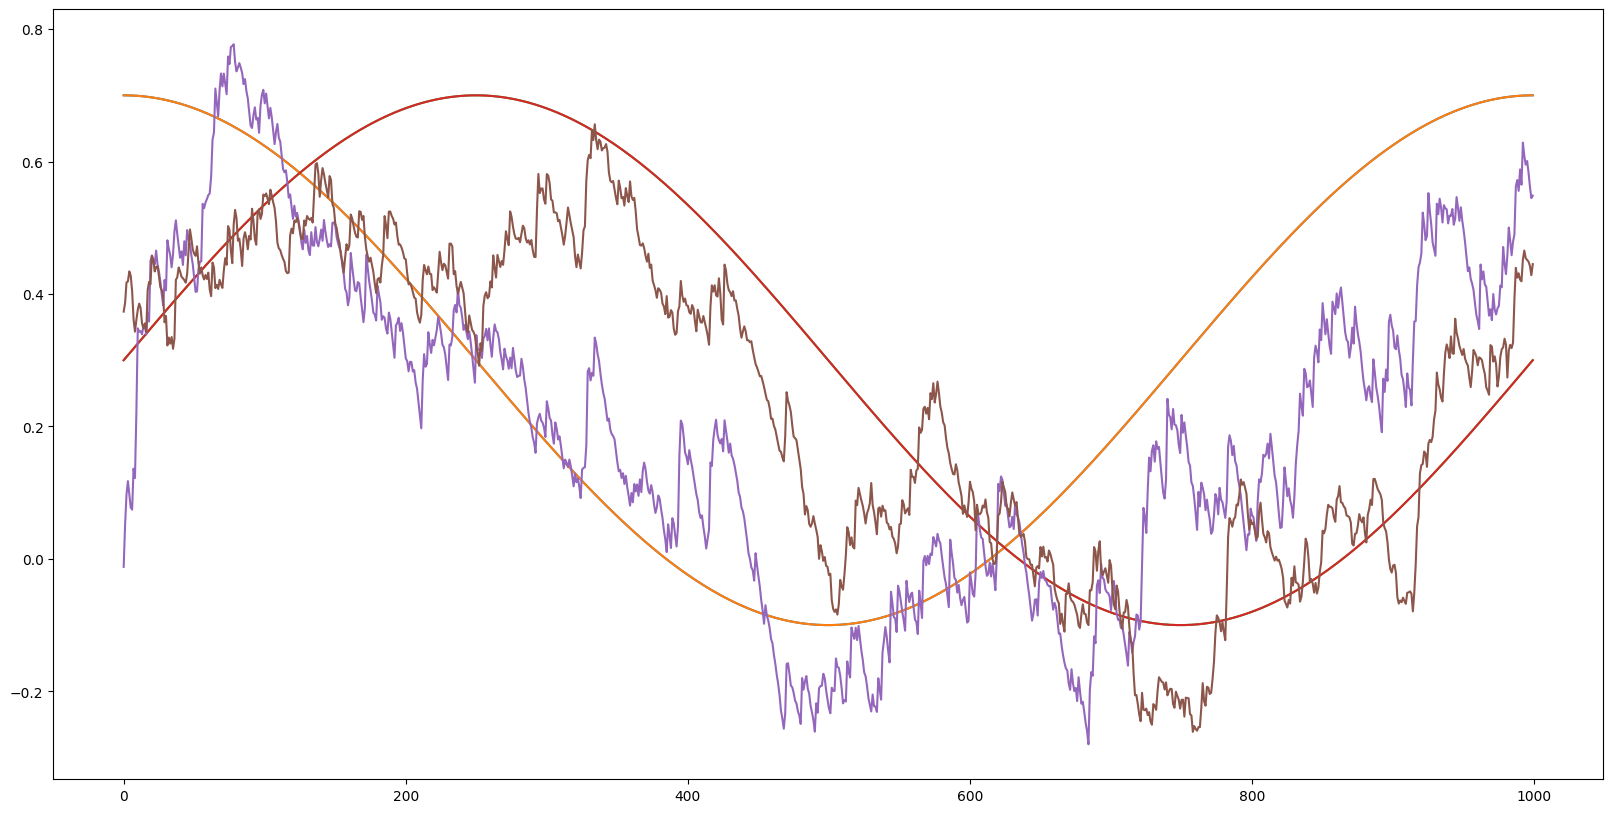

In [ ]:
print(f'The ML parameter values are:\n {Optimised.vTheta}\n')
print(f'The corresponding covariancematrix is: \n{Optimised.covariancematrix}\n')

print(f'The updated vector of cluster memberships is:\n {Optimised.updatedCm}\n')
plt.figure(figsize=(20,10))
plt.plot(x1[-1])
plt.plot(Optimised.filter)
plt.show()

# Things to try

## Parallelize the clustering algorithm

In [ ]:
def worker_task(args):
    j, i, value, Cm_star, vData, iW, X, R, MinlenCluster, vTheta,g = args
    Cm_star[j] = value
    vLikelihoods = 0
    Y = (vData, iW, X, Cm_star, R)
    val, vLikelihoodValues = fFilterSAR(Y, MinlenCluster, vTheta)
    vLikelihoods = -np.mean(vLikelihoodValues)
    return j, i, vLikelihoods

def fPosition(Cm_star,vLikelihoods,g,uniques,iN,MinlenCluster,vData,iW,X,R,vTheta):
      Cm_tilde = Cm_star.copy()
      tasks=[]

      for j in range(iN):
        for i, value in enumerate(uniques):
          tasks.append((j,i, value, Cm_star, vData, iW, X, R, MinlenCluster, vTheta,g))
      print(tasks[1])
      with Pool() as pool:
        results = pool.map(worker_task, tasks)
      for j,i, likelihood in results:
        vLikelihoods[j][i] = likelihood
      for j in range(iN):
        Cm_star[j] = np.argmin(vLikelihoods[j])
      if (Cm_star == Cm_tilde).all():
        NotDone=False
      else:
        NotDone = True
      return NotDone, Cm_star

fPosition([0,0,1,1],np.zeros((4, 2), dtype=np.float64),2,np.unique([0,1]),4,1,x1[0],x1[1],x1[2],x1[-1],[0.9,0.04,0.3,0.1])

## Try different clustering using centroids

[[[ 2.06250905  1.69023341]
  [ 2.07953995  0.06746851]
  [ 1.23542172  0.2539223 ]
  ...
  [ 0.48736679 -0.9764664 ]
  [ 0.26303472 -0.40014698]
  [ 0.96440511 -0.54567206]]

 [[ 1.41718797  1.00127355]
  [ 1.43421887 -0.62149135]
  [ 0.59010064 -0.43503756]
  ...
  [-0.15795429 -1.66542625]
  [-0.38228636 -1.08910684]
  [ 0.31908403 -1.23463192]]

 [[ 1.43711901  1.42870202]
  [ 1.45414991 -0.19406288]
  [ 0.61003167 -0.00760909]
  ...
  [-0.13802326 -1.23799778]
  [-0.36235533 -0.66167837]
  [ 0.33901507 -0.80720345]]]


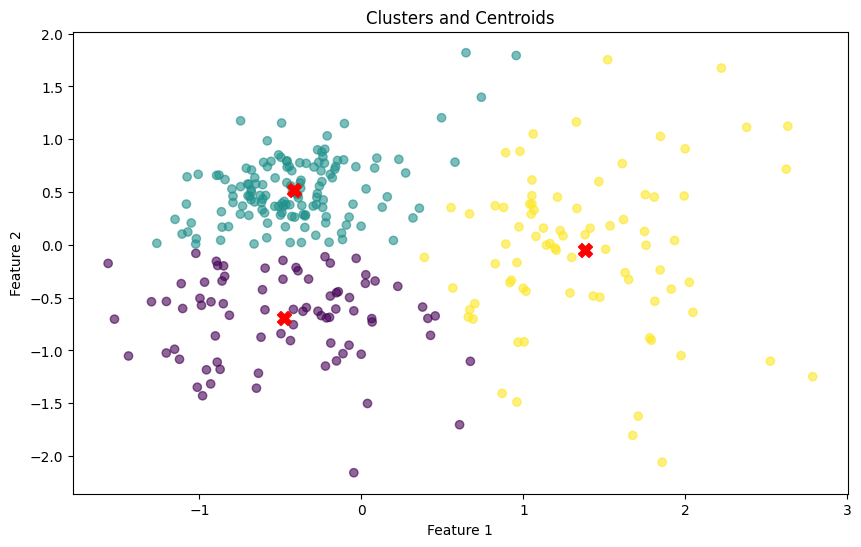

In [ ]:
def assign_points_to_centroids(data, centroids):
    distances = np.sqrt(((data - centroids[:, np.newaxis])**2).sum(axis=2))
    return np.argmin(distances, axis=0)

def update_centroids(data, assignments, k):
    new_centroids = np.array([data[assignments == i].mean(axis=0) for i in range(k)])
    return new_centroids

def EXAMPLE_tryCluster():
  data = np.vstack([np.random.randn(100, 2) * 0.75 + np.array([1, 0,]), np.random.randn(100, 2) * 0.25 + np.array([-0.5, 0.5]), np.random.randn(100, 2) * 0.5 + np.array([-0.5, -0.5])])
  centroids = data[np.random.choice(data.shape[0], 3, replace=False), :]
  print(data-centroids[:, np.newaxis])
  for i in range(120):
    assignments = assign_points_to_centroids(data, centroids)
    new_centroids = update_centroids(data, assignments, 3)
    if np.all(centroids == new_centroids):
        break
    centroids = new_centroids


  plt.figure(figsize=(10, 6))
  plt.scatter(data[:, 0], data[:, 1], c=assignments, alpha=0.6, cmap='viridis')
  plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, marker='X')  # Centroids
  plt.title('Clusters and Centroids')
  plt.xlabel('Feature 1')
  plt.ylabel('Feature 2')
  plt.show()
EXAMPLE_tryCluster()